<a href="https://colab.research.google.com/github/linhoangce/ml_with_pytorch_and_scikitlearn/blob/main/chapter7_ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning with ensembles

The goal of **ensemble methods** is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone.

This chaper focuses on the most popular ensemble methods that use the ** majority voting** principle. Majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50 percent of the votes.

In [ ]:
from scipy.special import comb
import math

# implement the probability mass function
def ensemble_error(n_classifiers, error):
  k_start = int(math.ceil(n_classifiers / 2.))
  probs = [comb(n_classifiers, k) *
           error**k *
           (1 - error)**(n_classifiers - k)
           for k in range(k_start, n_classifiers + 1)]
  return sum(probs)

ensemble_error(n_classifiers=11, error=0.25)

np.float64(0.03432750701904297)

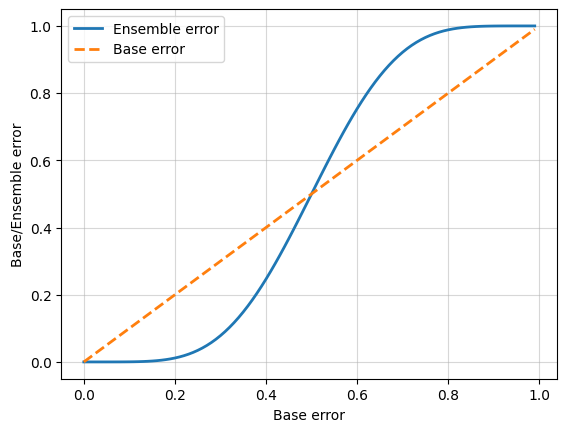

In [ ]:
# visulaize relationship between ensemble and base errors
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange(0.0, 1.0, 0.01)
ens_errors = [ensemble_error(n_classifiers=11, error=error)
              for error in error_range]

plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--',
         label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

# Combining classifier via majority vote

## Implementing a simple majority vote classifier

If the  weights of all base classifiers are equal, the majority vote predicts:

`C1(x) -> 0, C2(x) -> 0, C3(x) -> 1 then y_pred = mode[0,0,1] = 0`

If C3 weight is 0.6, C1 and C2 weights are both 0.2, then the prediction made by C3 has three times more weight than the predictions by C1 or C2, or:

`y_pred = mode[0,0,1,1,1] = 1`

In statistics, the mode is the most frequent event or result in a set.

In [ ]:
# `bincount` counts the number of occurrences of each class label
import numpy as np

np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

np.int64(1)

Certain classifiers in scikit-learn can also return probability of predicted class label via the `predict_proba` method.

𝐶1(𝒙) → [0.9, 0.1], 𝐶2(𝒙) → [0.8, 0.2], 𝐶3(𝒙) → [0.4, 0.6]

Using same weights (0.2, 0.2, 0.6):

𝑝(𝑖0|𝒙) = 0.2 × 0.9 + 0.2 × 0.8 + 0.6 × 0.4 = 0.58

𝑝(𝑖1|𝒙) = 0.2 × 0.1 + 0.2 × 0.2 + 0.6 × 0.6 = 0.42

y_pred = argmax_i[p(i0|x), p(i1|x)] = 0

In [ ]:
# implement weighted majority vote based on class probs
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [ ]:
np.argmax(p)

np.int64(0)

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
import sklearn

# reverse parent classes due to deprecation of `_estimator_type`
# https://github.com/rasbt/machine-learning-book/discussions/205
base_classifiers = (ClassifierMixin, BaseEstimator) if sklearn.__version__ >= '0.16' else (BaseEstimator, ClassifierMixin)

class MajorityVoteClassifier(*base_classifiers):
  """
  A majority vote ensemble classifier

  Parameters
  ----------
  classifiers: array-like, shape=[n_classifiers]
    Different classifiers for the ensemble

  vote: str, {'classlabel', 'probability'} {default='classlabel}
    If 'classlabel' the prediction is based on the argmax of
      class labels. Else if 'probability', the argmax of the sum
      of probabilities is used to predict the class label
      (recommended for calibrated classifiers).

  weights: array-like, shape = [n_classifiers], optional (default=None)
    If a list of `int` or `float` values are provided, the classifiers
    are weighted by importance; Uses uniform weights if `weights=None`.

  """
  def __init__(self,
               classifiers,
               vote='classlabel',
               weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {key: value for key, value
                              in _name_estimators(classifiers)}
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):
    """Fit classifiers.

    Parameters
    ----------
    X: {array-like, sparse matrix}, shape = [n_examples, n_features]
        Matrices of training examples

    y: array-like, shape = [n_examples]
        Vector of target class labels.

    Returns
    -------
    self : object

    """
    if self.vote not in ('probability', 'classlabel'):
      raise ValueError(f'Vote must be "probability" or "classlabel";'
                        f'got (vote={self.vote})')

    if self.weights and len(self.weights) != len(self.classifiers):
      raise ValueError(f'Number of classifiers and weights must be'
                        f'equal; got {len(self.weights)} '
                        f'{len(self.classifiers)} classifiers')

    # Use LabelEncoder to ensure class labels starts with 0,
    # which is important for np.argmax call in self.predict
    self.label_enc_ = LabelEncoder()
    self.label_enc_.fit(y)
    self.classes_ = self.label_enc_.classes_
    self.classifiers_ = []

    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X,
                                  self.label_enc_.transform(y))
      self.classifiers_.append(fitted_clf)

    return self

  def predict(self, X):
    """Predict class labels for X.

    Parameters
    ----------
    X: {array-like, sparse matrix}, shape = [n_examples, n_features]
        Matrix of training examples.

    Return
    ------
    maj_vote : array-like, shape = [n_examples]
        Predicted class labels.

    """
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X),
                           axis=1)
    else: # 'classlabel' vote

      # collect results from clf.predict calls
      predictions = np.asarray([
          clf.predict(X) for clf in self.classifiers_]).T

      maj_vote = np.apply_along_axis(
          lambda x: np.argmax(np.bincount(x, weights=self.weights)),
          axis=1,
          arr=predictions
      )

    maj_vote = self.label_enc_.inverse_transform(maj_vote)

    return maj_vote

  def predict_proba(self, X):
    """Predict class probability for X.

    Parameters
    ----------
    X : {array-like, sparse matrix}, shape = [n_examples, n_features]
        Matrix of training examples.

    Return
    ------
    avg_proba : array-like, shape = [n_examples, n_features]
        Weighted average probability for each class per example.

    """
    probas = np.asarray([clf.predict_proba(X)
                        for clf in self.classifiers_])
    avg_proba = np.average(probas, axis=0, weights=self.weights)

    return avg_proba

  def get_params(self, deep=True):
    """ Get classifier parameter names for GridSearch """
    if not deep:
      return super().get_params(deep=False)
    else:
      out = self.named_classifiers.copy()
      for name, step in self.named_classifiers.items():
        for key, value in step.get_params(deep=True).items():
          out[f'{name}__{key}'] = value

      return out

## Using the majority voting principle to make predictions


In [ ]:
# load Iris datset from scikit-learn's dataset module
# only select two features, sepal width and petal length
# only classify flower examples from Iris-versicolor
# Iris-verginica calsses
# compute the ROC AUC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
X[:5], y[:5]

(array([[3.2, 4.7],
        [3.2, 4.5],
        [3.1, 4.9],
        [2.3, 4. ],
        [2.8, 4.6]]),
 array([1, 1, 1, 1, 1]))

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=1,
                                                    stratify=y)
len(X_train), len(y_train)

(50, 50)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]]
                 )
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  print('\n', clf)
  scores = cross_val_score(estimator=clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring='roc_auc')
  print(f'ROC AUC: {scores.mean():.2f}'
        f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:


 Pipeline(steps=[['sc', StandardScaler()],
                ['clf', LogisticRegression(C=0.001, random_state=1)]])
ROC AUC: 0.92(+/- 0.15) [Logistic Regression]

 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
ROC AUC: 0.87(+/- 0.18) [Decision Tree]

 Pipeline(steps=[['sc', StandardScaler()],
                ['clf', KNeighborsClassifier(n_neighbors=1)]])
ROC AUC: 0.85(+/- 0.13) [KNN]


In [ ]:
_name_estimators(pipe1)

[('standardscaler', StandardScaler()),
 ('logisticregression', LogisticRegression(C=0.001, random_state=1))]

In [ ]:
from sklearn.pipeline import make_pipeline

p = make_pipeline(StandardScaler(),
                  LogisticRegression())
p



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipe1

Pipeline(steps=[['sc', StandardScaler()],
                ['clf', LogisticRegression(C=0.001, random_state=1)]])

In [ ]:
# combine individual classifiers for majority rule voting
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3],
)
clf_labels += ['Najority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X=X_train,
                           y=y_train,
                           cv=10,
                           scoring='roc_auc')
  print(f'ROC AUC: {scores.mean():.2f} '
        f'(+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.92 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Najority voting]


## Evaluating and tuning the ensemble classifier

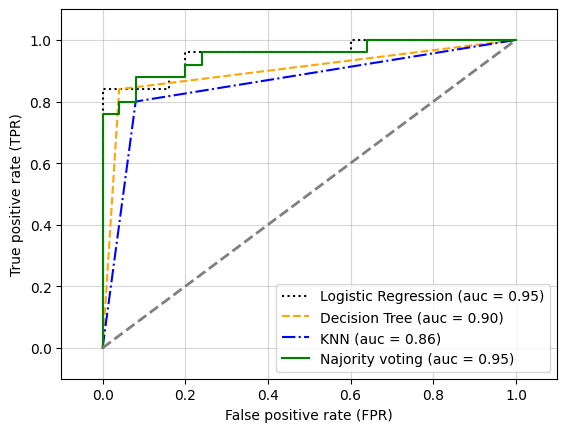

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf,
                               clf_labels,
                               colors,
                               linestyles):
  # assuming the label of the positive class is 1
  y_pred = clf.fit(X_train,
                   y_train).predict_proba(X_test)[:, 1]
  fpr, tpr, threshold = roc_curve(y_true=y_test,
                                  y_score=y_pred)
  roc_auc = auc(x=fpr,
                y=tpr)

  plt.plot(fpr,
           tpr,
           color=clr,
           linestyle=ls,
           label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim(-.1, 1.1)
plt.ylim(-.1, 1.1)
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [ ]:
# Standardize training features for plotting with
# decision boundary
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)


(4690, 2)
(4690, 2)
(4690, 2)
(4690, 2)


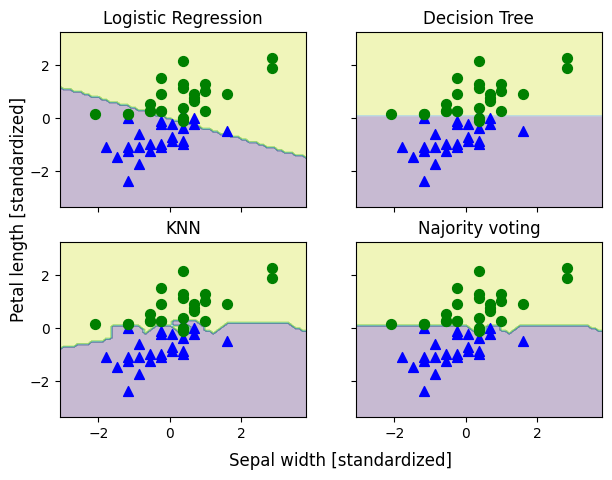

In [ ]:
from itertools import product

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2,
                        ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
  clf.fit(X_train_std, y_train)
  print(np.c_[xx.ravel(), yy.ravel()].shape)
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

  axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                X_train_std[y_train == 0, 1],
                                c='blue',
                                marker='^',
                                s=50)

  axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                X_train_std[y_train==1, 1],
                                c='green',
                                marker='o',
                                s=50)

  axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.0,
         s='Sepal width [standardized]',
         ha='center',
         va='center',
         fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center',
         va='center',
         fontsize=12,
         rotation=90)

plt.show()

In [ ]:
# view individual parameters inside GridSearch object
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [ ]:
# tune inverse regularization param C of LogReg classifier
# and decision tree depth via GridSearchCV
from sklearn.model_selection import GridSearchCV

params = { 'decisiontreeclassifier__max_depth': [1, 2],
           'pipeline-1__clf__C': [0.001, 0.01, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.01, 100.0]},
             scoring='roc_auc')

In [ ]:
# print different hyperparameter value combinations
# and average ROC AUC scores computed via 10-fold CV
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  mean_score = grid.cv_results_['mean_test_score'][r]
  std_dev = grid.cv_results_['std_test_score'][r]
  params = grid.cv_results_['params'][r]
  print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')


0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.01}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [ ]:
print(f'Best param: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.3f}')

Best param: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.983


In [ ]:
# `refit` is default to True for GridSearchCV
# make prediction after training
grid.predict(X_test), grid.score(X_test, y_test)

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0]),
 np.float64(0.9488))

In [ ]:
# access "best" estimator
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [ ]:
grid.best_estimator_.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [ ]:
mv_clf = grid.best_estimator_

# unpack dict of best hyperparams found by GridSearchCV
# using (**) syntax and pass to get_params()
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [ ]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

# Bagging - building an ensemble of classifiers from bootstrap samples

## Applying bagging to classify examples in the Wine dataset

In [ ]:
# create a more complex classification problem using Wine dataset
# use only classes 2 and 3, and select two feature =
# Alcohol and OD280/OD315 of diluted wines
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                     'machine-learning-databases/wine/wine.data',
                     header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
              'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
              'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

# extract features and labels
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values

X[:5], y[:5]

(array([[12.37,  1.82],
        [12.33,  1.67],
        [12.64,  1.59],
        [13.67,  2.46],
        [12.37,  2.87]]),
 array([2, 2, 2, 2, 2]))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)


In [ ]:
# use an unpruned decision tree as base classifier
# and create an ensemble of 500 decision trees
# to fit different bootstrap samples
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=None)

bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

bag

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   random_state=1),
                  n_estimators=500, n_jobs=1, random_state=1)

In [ ]:
# calculate pred score on training and test datasets
# to compare performance of bagging classifier to
# unpruned decision tree
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test acc: '
      f'{tree_train:.3f}/{tree_test:.3f}')

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print(f'Bagging train/test acc: {bag_train:.3f}/{bag_test:.3f}')

Decision tree train/test acc: 1.000/0.833
Bagging train/test acc: 1.000/0.917


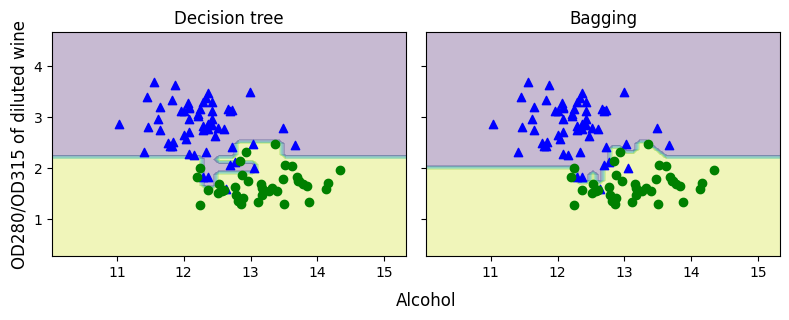

In [ ]:
# compare decision regions between decision tree and bagging classifier
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1,
                        ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))

for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
  clf.fit(X_train, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue',
                     marker='^')

  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1],
                     c='green',
                     marker='o')

  axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wine',
                    fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

# Leveraging weak learners via adaptive boosting

In boosting, the ensemble consists of very simple base classifiers, also often referred to as **weak learners**, which often only have a slight performance advantage over random guessing - a typical example of weak learner is a decision tree stump. The key concept behind boosting is to focus on training examples that are hard to classify, that is, to let the weak learners subsequently learn from misclassified training examples to improve the performance of the ensemble.

## How adaptive boosting works

In contrast to bagging, the initial formulation of the boosting algorithm uses random subsets of training examples drawn from the training dataset without replacement; the original boosting procedure can be summarized the following four key steps:

1. Draw a random subset (sample) of training examples, *d1*, without replacement from the training dataset, *D*, to train a weak learn, *C1*.
2. Draw a second random training subset, *d2*, without replacement from the training dataset and add 50 percent of the examples that were previously misclassified to train a weak learner, *C2*.
3. Find the training examples, *d3*, in the training dataset, *D*, which *C1* and *C2* disagree upon, to train a third weak learner, *C3*.
4. Combine the weak learners C1, C2, and C3 via majority voting.

In contrast to the original boosting procedure described here, AdaBoost uses the complete training dataset to train the weak learners, where the training examples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.

In [ ]:
# follow calculation step by step
# start by computing the weighted error rate epsilon
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
weights

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
correct

array([ True,  True,  True,  True,  True,  True, False, False, False,
        True])

In [ ]:
~correct # invert T -> F

array([False, False, False, False, False, False,  True,  True,  True,
       False])

In [ ]:
# compute the proportion of incorrect predictions
# by invert `correct` array so that True counts as value 1
# and False as 0, that is, the classification error.
epsilon = np.mean(~correct)
epsilon

np.float64(0.3)

In [ ]:
# compute coefficient that is used to update weights
alpha_j = 0.5 *  np.log((1 - epsilon) / epsilon)
alpha_j

np.float64(0.42364893019360184)

In [ ]:
# update weight vector using w:= w * exp(-alpha_j X yhat X y)
# `yhat X y` is an element-wise multiplication between vectors
# of predicted and true class labels
# if a prediction, yhat, is correct, yhat X y will have positive sign
# that decreases the ith weight, since alpha_j is positive
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
update_if_correct

np.float64(0.06546536707079771)

In [ ]:
#
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
update_if_wrong_1

np.float64(0.1527525231651947)

In [ ]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * 1 * -1)
update_if_wrong_2

np.float64(0.1527525231651947)

In [ ]:
# assign `update_if_correct` value to all correct preds
# and `update_if_wrong` value to all wrong preds.
weights = np.where(correct == 1,
                   update_if_correct,
                   update_if_wrong_1)
weights

array([0.06546537, 0.06546537, 0.06546537, 0.06546537, 0.06546537,
       0.06546537, 0.15275252, 0.15275252, 0.15275252, 0.06546537])

In [ ]:
# normalize weights so they sum up to 1
normalized_weights = weights / np.sum(weights)
normalized_weights

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.16666667, 0.16666667, 0.16666667, 0.07142857])

The above cell output shows that each weight that corresponds to a correctly classified example will be reduced from the initial value of 1.0 to 0.0714 for the next round of boosting. Similarly, the weights of the incorrectly classified examples will increase from 0.1 to 0.1667

## Applying AdaBoost using scikit-learn

In [ ]:
# train a bagging meta-classifier with Wine subset
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test accuracies: '
      f'{tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print(f'AdaBoost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies: 0.916/0.875
AdaBoost train/test accuracies: 0.968/0.917


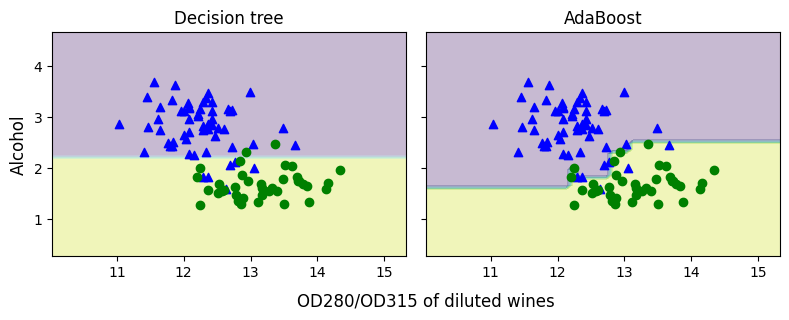

In [ ]:
# plot decision boundary
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1,
                        ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))

for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
  clf.fit(X_train, y_train)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  axarr[idx].contourf(xx, yy, Z, alpha=0.3)
  axarr[idx].scatter(X_train[y_train==0, 0],
                     X_train[y_train==0, 1],
                     c='blue',
                     marker='^')

  axarr[idx].scatter(X_train[y_train==1, 0],
                     X_train[y_train==1, 1],
                     c='green',
                     marker='o')

  axarr[idx].set_title(tt)
  axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

# Gradient Boosting - training an ensemble based on loss gradients

## Comparing AdaBoost with gradient boosting

AdaBoost trains decision tree stumps based on errors of the previous decision tree stump. In particular, the errors are used to compute sample weights in each round as well as for computing a classifier weight for each decision tree stump when combining the individual stumps into an ensemble. We stop training once a maximum number of iterations (decision tree stumps) is reached. Like AdaBoost, **gradient boosting** fits decision trees in an iterative fashion using prediction errors. However, gradient boosting trees are usually deeper than decision stumps and have typically a maximum of depth of 3 to 6 (or a maximum number of 8 to 64 leaf nodes). Also, in contrast to AdaBoost, gradient boosting does not use the prediction errors for assigning sample weights; they are used direcly to form the target variable for fitting the next tree. Moreover, instead of having an individual weighting term for each tree, like in AdaBoost, gradient boosting uses a global learning rate that is the same for each tree.

## Using XGBoost

In [ ]:
import xgboost as xgb
xgb.__version__

'3.0.2'

In [ ]:
model = xgb.XGBClassifier(n_estimators=1000,
                          learning_rate=0.01,
                          max_depth=4,
                          random_state=1)

gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)

print(f'XGBoost train/test accuracies: {gbm_train:.3f}/{gbm_test:.3f}')

XGBoost train/test accuracies: 0.968/0.917
